In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fredapi as fa

##### Functions

In [2]:
def model_describe(model, returns):
    dfs = []
    cycle_df = returns[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom', model]].apply(pd.to_numeric, errors='coerce').dropna()
    cycle_df[model] = cycle_df[model].round()
    for x in range(1,5):
        cycle = cycle_df.loc[cycle_df[model]==x]
        count = cycle_df.loc[cycle_df[model]==x].describe()[model][0]
        #print("Descriptive Stats during cycle {} which is {}/{}".format(x, count, len(cycle_df)))
        #print(cycle.describe()[['Mkt-RF','SMB','HML','RMW','CMA','Mom']].round(4))
        dfs.append(cycle.describe()[['Mkt-RF','SMB','HML','RMW','CMA','Mom']].round(4))
    return dfs

In [3]:
def returns_data(model, returns, opt, optw):    
    strat = returns.apply(pd.to_numeric, errors='coerce').dropna()
    strat[model] = strat[model].round()
    #set up empy cells with for the weights
    for col in strat.columns:
        if 'cycle' in col:
            continue
        if 'Mkt' in col:
            continue
        else:
            strat[col + '_weight'] = 0
    #weight the cycle returns
    for col in strat.columns:
        if ('weight' in col) & (opt[0] in col):
            strat[col] = np.where(strat[model] == 1,optw[0],strat[col])
        if ('weight' in col) & (opt[1] in col):
            strat[col] = np.where(strat[model] == 2,optw[1],strat[col])
        if ('weight' in col) & (opt[2] in col):
            strat[col] = np.where(strat[model] == 3,optw[2],strat[col])
        if ('weight' in col) & (opt[3] in col):
            strat[col] = np.where(strat[model] == 4,optw[3],strat[col])

    #combine the returns
    strat['Rotation_return'] = strat['SMB']*strat['SMB_weight'] + \
                                strat['HML']*strat['HML_weight'] + \
                                strat['RMW']*strat['RMW_weight'] + \
                                strat['CMA']*strat['CMA_weight'] + \
                                strat['Mom']*strat['Mom_weight']
    strat = strat[['Mkt-RF','Rotation_return',model]]   

    #get cumaltive returns
    strat['Market'] = (strat['Mkt-RF']+1).cumprod()-1
    strat['Strategy'] = (strat['Rotation_return']+1).cumprod()-1
    return strat

In [4]:
#plot returns - add start and end dates
def cum_plot(df):
    plt.figure(figsize = (12,8))
    plt.plot(df.index,df['Market'], label='Market')
    plt.plot(df.index,df['Strategy'], label='Strategy')

    plt.title("Cumulative Returns", fontsize = 30)

    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

def stats(df, time):
    #in qtrs may change to monthly
    mkt_vol = df['Mkt-RF'].std() * np.sqrt(time)
    mkt_ret = (df['Market'][-1]+1)**(1/(len(df)/time))-1
    mkt_sharpe = mkt_ret/mkt_vol

    strat_vol = df['Rotation_return'].std() * np.sqrt(time)
    strat_ret = (df['Strategy'][-1]+1)**(1/(len(df)/time))-1
    strat_sharpe = strat_ret/strat_vol


    #output important results
    print("Market Return: {}%".format((100*mkt_ret).round(2)))
    print("Market Vol: {}%".format((100*mkt_vol).round(2)))
    print("Market Sharpe: {}".format(mkt_sharpe.round(2)))
    print("")

    print("Strategy Return: {}%".format((100*strat_ret).round(2)))
    print("Strategy Vol: {}%".format((100*strat_vol).round(2)))
    print("Strategy Sharpe: {}".format(strat_sharpe.round(2)))

#### Get Quarterly data for models

In [28]:
#pull data from FRED
fred = fa.Fred(api_key='b6bbb1bfe76d93bf0ca60a69b99d3474')

#CPI
cpi = fred.get_series('CPIAUCSL')
cpi.name = 'CPI'

cpi_data = pd.DataFrame(index=cpi.index,data=cpi.values,columns=['CPI']).dropna()
cpi_data['CPI YOY'] = cpi_data['CPI'].rolling(12).apply(lambda x: (x.iloc[-1]/x.iloc[0] - 1) *100 )
cpi_data['CPI'] = cpi_data['CPI YOY'].rolling(12).apply(lambda x: x.iloc[-1] -x.iloc[0] - 1)
cpi_data = cpi_data.dropna()

#GDP
gdp = fred.get_series('GDP')
gdp.name = 'GDP'

gdp_data = pd.DataFrame(index=gdp.index,data=gdp.values,columns=['GDP']).dropna()
gdp_data['GDP YOY'] = gdp_data['GDP'].rolling(4).apply(lambda x: (x.iloc[-1]/x.iloc[0] - 1) *100 )
gdp_data['GDP'] = gdp_data['GDP YOY'].rolling(4).apply(lambda x: x.iloc[-1] -x.iloc[0] - 1)
gdp_data = gdp_data.dropna()

#merge data
df = pd.concat([gdp_data, cpi_data], axis=1).dropna()

#make cycle
conditions = [
    (df['CPI'] < 0.0) & (df['GDP'] >= 0.0),
    (df['CPI'] >= 0.0) & (df['GDP'] >= 0.0), #& (df['GDP YOY'] > 0.5),
    (df['CPI'] < 0.0) & (df['GDP'] < 0.0)]
choices = [1.0, 2.0, 4.0]
df['cycle_gdp_cpi'] = np.select(conditions, choices, default=3.0)

#shift to get the 1 qtr
df = df.shift(1).dropna()

In [41]:
#HY Cycle builder
hyoas = fred.get_series('BAMLH0A0HYM2')
hyoas.name = 'HY_OAS'

data = pd.DataFrame(index=hyoas.index, data=hyoas.values, columns=['HY OAS']).dropna()

#ten year median
median_10y = data['HY OAS'].rolling('3650D').median()

#3 month rising or falling: 1 is rising
return_3m = (data['HY OAS'].pct_change() + 1).rolling('91D').apply(np.prod) - 1
return_3m = pd.DataFrame(index= return_3m.index, data=np.where(return_3m > 0, 1, 0))

#add to data frame
data['10y Median'] = median_10y
data['3M Up/Down'] = return_3m

#make HY cycle
conditions = [
    (data['HY OAS'] > data['10y Median']) & (data['3M Up/Down'] == 0),
    (data['HY OAS'] < data['10y Median']) & (data['3M Up/Down'] == 0),
    (data['HY OAS'] < data['10y Median']) & (data['3M Up/Down'] == 1)
]

choices = [1, 2, 3]

data['cycle_hy'] = np.select(conditions, choices, default=4)

data = data.shift(1).dropna()

#convert to qtrly to match GDP - may want both in monthly
data = data.resample('Q', label='left').mean() #may want to round
data = data.reset_index()
data['date'] = data['index'] + pd.DateOffset(1)
data = data[['date','cycle_hy']]
data.set_index('date',inplace=True)


#combine both HY and GDP
model_df = pd.concat([data, df], axis=1)
model_df = model_df[['cycle_hy','cycle_gdp_cpi']].fillna('-')
#model_df


1996-12-31    4
1997-01-02    2
1997-01-03    4
1997-01-06    1
1997-01-07    4
             ..
2022-10-04    1
2022-10-05    1
2022-10-06    1
2022-10-07    1
2022-10-10    1
Name: cycle_hy, Length: 6729, dtype: int64


Returns from the factors

In [30]:
# triage walts code

from support import fama_french
facts = fama_french()
cols = facts.columns.to_list()
# facts.head()
cols[0] = 'Mkt-RF'
cols[5] = 'Mom'
facts.columns = cols
facts = facts.drop("RF", axis=1)

In [31]:
# facts = pd.read_csv("Factors.csv",header=3)
# facts = facts.drop("String",axis=1)
# facts['Date'] = pd.to_datetime(facts['Date'])
# facts = facts.set_index("Date")
# facts = facts.apply(pd.to_numeric)/100

#resample to qtrs to match the
facts += 1
facts = facts.rolling(3).apply(lambda x: x.prod()-1).dropna()
#facts.describe()#.to_excel('Factor Des Stats.xlsx')

#merge to get model and return
returns = pd.concat([facts, model_df], axis=1).dropna()
returns = returns[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom', 'cycle_hy', 'cycle_gdp_cpi']]
returns

,Mkt-RF,SMB,HML,RMW,CMA,Mom,cycle_hy,cycle_gdp_cpi
1963-10-01,0.060369,-0.026875,0.018304,0.024376,-0.020698,0.043594,-,1.0
1964-01-01,0.032260,-0.028354,0.032352,-0.003110,0.036703,0.018656,-,1.0
1964-04-01,0.030747,-0.000296,0.055933,-0.035002,0.030344,0.004261,-,1.0
1964-07-01,0.044952,0.001565,0.032602,-0.003599,0.019097,0.026812,-,4.0
1964-10-01,0.018084,0.009392,0.029722,-0.008688,0.014467,-0.005496,-,4.0
...,...,...,...,...,...,...,...,...
2021-07-01,0.043567,-0.037751,-0.030309,0.058010,0.015417,0.007801,2.343284,2.0
2021-10-01,0.049573,-0.022501,0.044083,-0.005512,-0.011026,0.073981,2.5,2.0
2022-01-01,-0.048419,-0.064645,0.159358,0.134739,0.144387,-0.042688,2.828125,3.0
2022-04-01,-0.088351,0.003434,0.074486,-0.001085,0.126981,0.099381,3.538462,3.0


### GDP and Inflation - Qtrly

In [32]:
returns

,Mkt-RF,SMB,HML,RMW,CMA,Mom,cycle_hy,cycle_gdp_cpi
1963-10-01,0.060369,-0.026875,0.018304,0.024376,-0.020698,0.043594,-,1.0
1964-01-01,0.032260,-0.028354,0.032352,-0.003110,0.036703,0.018656,-,1.0
1964-04-01,0.030747,-0.000296,0.055933,-0.035002,0.030344,0.004261,-,1.0
1964-07-01,0.044952,0.001565,0.032602,-0.003599,0.019097,0.026812,-,4.0
1964-10-01,0.018084,0.009392,0.029722,-0.008688,0.014467,-0.005496,-,4.0
...,...,...,...,...,...,...,...,...
2021-07-01,0.043567,-0.037751,-0.030309,0.058010,0.015417,0.007801,2.343284,2.0
2021-10-01,0.049573,-0.022501,0.044083,-0.005512,-0.011026,0.073981,2.5,2.0
2022-01-01,-0.048419,-0.064645,0.159358,0.134739,0.144387,-0.042688,2.828125,3.0
2022-04-01,-0.088351,0.003434,0.074486,-0.001085,0.126981,0.099381,3.538462,3.0


In [33]:
# returns is df of factor returns, mkt, smb, hml, rmw, cma, mom + cycle_hy and cycle_gdp_cpi cols

gdp_model = model_describe('cycle_gdp_cpi', returns)
# returns list of dfs

In [48]:
gdp_model[0].loc["mean"]

Mkt-RF    0.0187
SMB       0.0071
HML       0.0286
RMW       0.0097
CMA       0.0114
Mom       0.0197
Name: mean, dtype: float64

In [42]:
gdp_model[1]

,Mkt-RF,SMB,HML,RMW,CMA,Mom
count,17.0000,17.0000,17.0000,17.0000,17.0000,17.0000
mean,0.0069,0.0199,0.0082,0.0040,0.0103,0.0005
std,0.0835,0.0562,0.0528,0.0275,0.0312,0.0556
min,-0.2260,-0.0859,-0.0743,-0.0478,-0.0469,-0.0941
25%,-0.0199,-0.0225,-0.0303,-0.0055,-0.0110,-0.0219
50%,0.0295,0.0239,0.0277,0.0087,0.0154,0.0019
75%,0.0496,0.0640,0.0421,0.0171,0.0374,0.0294
max,0.1212,0.1105,0.0856,0.0580,0.0531,0.1104


In [43]:
gdp_model[2]

,Mkt-RF,SMB,HML,RMW,CMA,Mom
count,44.0000,44.0000,44.0000,44.0000,44.0000,44.0000
mean,-0.0090,0.0001,0.0115,0.0114,0.0167,0.0211
std,0.0909,0.0626,0.0607,0.0549,0.0544,0.0762
min,-0.2373,-0.1118,-0.1557,-0.1713,-0.1027,-0.1464
25%,-0.0743,-0.0395,-0.0239,-0.0214,-0.0127,-0.0163
50%,-0.0084,-0.0148,0.0077,0.0199,0.0096,0.0146
75%,0.0639,0.0292,0.0385,0.0431,0.0452,0.0551
max,0.1552,0.1645,0.1594,0.1347,0.1444,0.2190


In [44]:
#change number to filter through the different cycle descriptive stats
gdp_model[3]

,Mkt-RF,SMB,HML,RMW,CMA,Mom
count,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000
mean,0.0264,0.0071,0.0005,0.0070,0.0051,0.0199
std,0.0664,0.0525,0.0504,0.0309,0.0355,0.0705
min,-0.1727,-0.1220,-0.1825,-0.0779,-0.1102,-0.3955
25%,-0.0157,-0.0294,-0.0265,-0.0123,-0.0192,-0.0036
50%,0.0259,0.0023,0.0012,0.0036,0.0057,0.0218
75%,0.0666,0.0373,0.0325,0.0241,0.0226,0.0533
max,0.2529,0.2001,0.1472,0.1098,0.1140,0.1988


### function for calcing returns based on strat

In [50]:
#inputs to custum strategy

#Gdp
gdp_opt_1 = 'Mom'
gdp_opt_2 = 'SMB'
gdp_opt_3 = 'HML' 
gdp_opt_4 = 'RMW' 

gdp_opt = [gdp_opt_1, gdp_opt_2, gdp_opt_3, gdp_opt_4]

gdp_opt_1w = 1
gdp_opt_2w = 1
gdp_opt_3w = 1
gdp_opt_4w = 1

gdp_opt_w = [gdp_opt_1w, gdp_opt_2w, gdp_opt_3w, gdp_opt_4w]

model = 'cycle_gdp_cpi'

In [51]:
returns_data(model, returns ,gdp_opt, gdp_opt_w)

,Mkt-RF,Rotation_return,cycle_gdp_cpi,Market,Strategy
1997-01-01,0.096555,0.001707,1.0,0.096555,0.001707
1997-04-01,-0.016774,0.044716,4.0,0.078162,0.046499
1997-07-01,0.192612,-0.003960,4.0,0.285828,0.042355
1997-10-01,-0.028592,-0.017491,4.0,0.249064,0.024122
1998-01-01,0.044958,0.044617,4.0,0.305220,0.069816
...,...,...,...,...,...
2021-04-01,0.111687,-0.125946,1.0,5.255958,0.798608
2021-07-01,0.043567,-0.037751,2.0,5.528510,0.730709
2021-10-01,0.049573,-0.022501,2.0,5.852147,0.691766
2022-01-01,-0.048419,0.159358,3.0,5.520371,0.961363


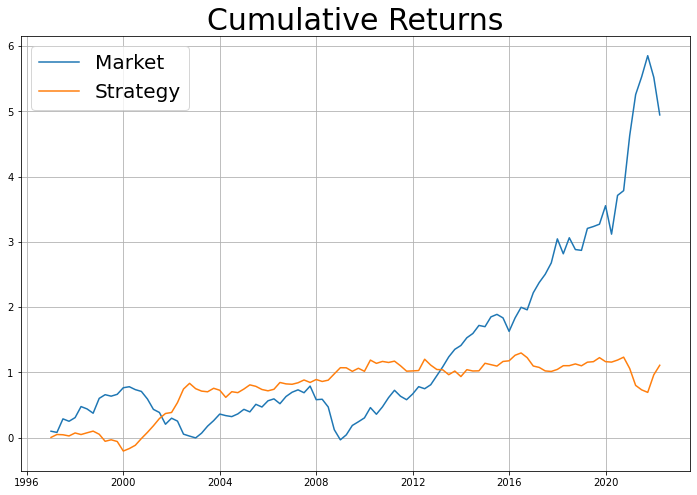

In [52]:
#add start and end dates
cum_plot(returns_data(model, returns ,gdp_opt, gdp_opt_w))

In [16]:
stats(returns_data(model, returns,gdp_opt,gdp_opt_w),4)

Market Return: 7.24%
Market Vol: 14.64%
Market Sharpe: 0.49

Strategy Return: 2.97%
Strategy Vol: 9.85%
Strategy Sharpe: 0.3


#### HY - Qtrly

In [17]:
hy_model = model_describe('cycle_hy', returns)
hy_model[3]

,Mkt-RF,SMB,HML,RMW,CMA,Mom
count,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000
mean,-0.0562,-0.0198,0.0156,0.0346,0.0202,0.0701
std,0.0797,0.0483,0.0534,0.0420,0.0529,0.0637
min,-0.2373,-0.1140,-0.0698,-0.0216,-0.0475,-0.0066
25%,-0.0884,-0.0456,-0.0241,-0.0011,-0.0001,0.0133
50%,-0.0250,-0.0282,0.0244,0.0338,0.0119,0.0608
75%,-0.0160,0.0025,0.0477,0.0718,0.0394,0.1051
max,0.0604,0.0812,0.1172,0.1043,0.1270,0.1988


In [18]:
#inputs to custum strategy

#Gdp
hy_opt_1 = 'SMB'
hy_opt_2 = 'SMB'
hy_opt_3 = 'Mom' 
hy_opt_4 = 'Mom' 

hy_opt = [hy_opt_1,hy_opt_2,hy_opt_3,hy_opt_4]

hy_opt_1w = 1
hy_opt_2w = 1
hy_opt_3w = 1
hy_opt_4w = 1

hy_opt_w = [hy_opt_1w,hy_opt_2w,hy_opt_3w,hy_opt_4w]

model = 'cycle_hy'

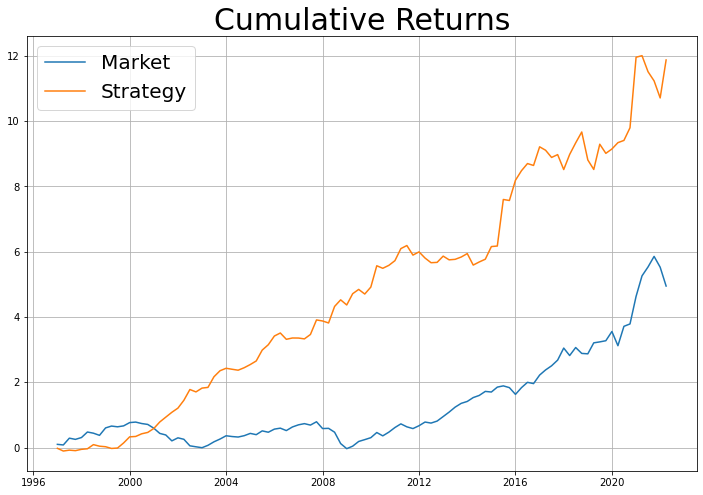

In [19]:
cum_plot(returns_data(model, returns,hy_opt,hy_opt_w))

In [20]:
stats(returns_data(model, returns,hy_opt,hy_opt_w),4)

Market Return: 7.24%
Market Vol: 14.64%
Market Sharpe: 0.49

Strategy Return: 10.54%
Strategy Vol: 11.1%
Strategy Sharpe: 0.95


# High Yield Model - Monthly

In [22]:
#HY Cycle builder
hyoas = fred.get_series('BAMLH0A0HYM2')
hyoas.name = 'HY_OAS'

data = pd.DataFrame(index=hyoas.index,data=hyoas.values,columns=['HY OAS']).dropna()

#ten year median
median_10y = data['HY OAS'].rolling('3650D').median()

#3 month rising or falling: 1 is rising
return_3m = (data['HY OAS'].pct_change()+1).rolling('91D').apply(np.prod)-1
return_3m = pd.DataFrame(index= return_3m.index, data= np.where(return_3m > 0, 1,0))

#add to data frame
data['10y Median'] = median_10y
data['3M Up/Down'] = return_3m

#make HY cycle
conditions = [
    (data['HY OAS']>data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==1)
]

choices = [1,2,3]

data['cycle_hy'] = np.select(conditions, choices, default = 4)

#lag by a day since it takes a day to get the HY OAS
data = data.shift(1).dropna()
#convert to monthly to match factor returns - reblance monthly
data = data.resample('M', label='left').mean() #may want to round
data = data.reset_index()
data['date'] = data['index'] + pd.DateOffset(1)
data = data[['date','cycle_hy']]
data.set_index('date',inplace=True)

# get factor data
# Walt <
# facts = pd.read_csv("Factors.csv",header=3)
# facts = facts.drop("String",axis=1)
# facts['Date'] = pd.to_datetime(facts['Date'])
# facts = facts.set_index("Date")
# facts = facts.apply(pd.to_numeric)/100
# facts.describe()#.to_excel('HY Factor Des Stats.xlsx')
# > end Walt

from support import fama_french
facts = fama_french()
cols = facts.columns.to_list()
cols[0] = 'Mkt-RF'
cols[5] = 'Mom'
facts.columns = cols
facts = facts.drop("RF", axis=1)

#merge to get model and return
returns_m = pd.concat([facts,data], axis=1).dropna()
returns_m

,Mkt-RF,SMB,HML,RMW,CMA,Mom,cycle_hy
1997-01-01,0.0499,-0.0182,-0.0142,0.0119,-0.0002,0.0196,2.272727
1997-02-01,-0.0049,-0.0259,0.0567,0.0067,0.0347,-0.0213,2.105263
1997-03-01,-0.0503,-0.0043,0.0339,0.0050,0.0166,0.0090,2.000000
1997-04-01,0.0404,-0.0570,0.0007,0.0326,-0.0072,0.0484,2.090909
1997-05-01,0.0674,0.0475,-0.0413,-0.0102,-0.0296,-0.0517,1.954545
...,...,...,...,...,...,...,...
2022-04-01,-0.0946,-0.0040,0.0619,0.0363,0.0592,0.0489,3.000000
2022-05-01,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0248,3.681818
2022-06-01,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0079,3.909091
2022-07-01,0.0957,0.0187,-0.0410,0.0068,-0.0694,-0.0396,4.000000


In [23]:
hy_model_month = model_describe('cycle_hy',returns_m)

In [24]:
hy_model_month[0]

,Mkt-RF,SMB,HML,RMW,CMA,Mom
count,49.0000,49.0000,49.0000,49.0000,49.0000,49.0000
mean,0.0111,0.0105,0.0066,0.0012,0.0057,-0.0011
std,0.0477,0.0293,0.0353,0.0341,0.0273,0.0798
min,-0.1005,-0.0523,-0.0832,-0.0760,-0.0677,-0.3430
25%,-0.0246,-0.0062,-0.0149,-0.0169,-0.0076,-0.0479
50%,0.0142,0.0104,0.0043,-0.0027,0.0035,0.0142
75%,0.0442,0.0273,0.0246,0.0131,0.0243,0.0375
max,0.1018,0.0713,0.1248,0.0911,0.0905,0.1322


#### Get Trading Rotations

In [25]:
#inputs to custum strategy

#HY
opt_1 = 'SMB'
opt_2 = 'SMB'
opt_3 = 'Mom'
opt_4 = 'RMW'

rotate_m = [opt_1,opt_2,opt_3,opt_4]

opt_1w = 1
opt_2w = 1
opt_3w = 1
opt_4w = 1

rotate_w_m = [opt_1w,opt_2w,opt_3w,opt_4w]

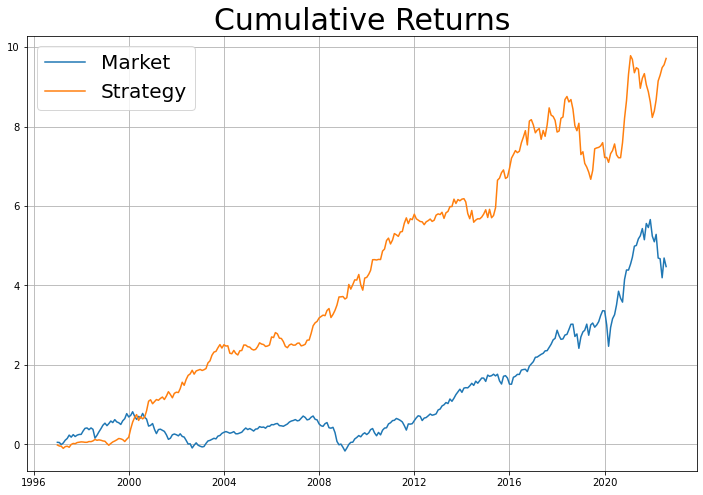

In [26]:
cum_plot(returns_data('cycle_hy', returns_m,rotate_m,rotate_w_m))

### HY Monthly Stats - Total Period

In [27]:
stats(returns_data('cycle_hy', returns_m,rotate_m,rotate_w_m),12)

Market Return: 6.85%
Market Vol: 16.1%
Market Sharpe: 0.43

Strategy Return: 9.68%
Strategy Vol: 10.82%
Strategy Sharpe: 0.89
